In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [3]:
from sklearn.model_selection import StratifiedKFold

In [4]:
from sklearn.preprocessing import Normalizer

In [5]:
import xgboost as xgb

In [6]:
from sklearn.model_selection import GridSearchCV

In [7]:
def GridSearch_table_(grid_clf, param_name,
                          num_results=15,
                          negative=False,
                          graph=True,
                          display_all_params=True):
                        
    from matplotlib      import pyplot as plt
    from IPython.display import display
    import pandas as pd

    clf = grid_clf.best_estimator_
    clf_params = grid_clf.best_params_
    if negative:
        clf_score = -grid_clf.best_score_
    else:
        clf_score = grid_clf.best_score_
    clf_stdev = grid_clf.cv_results_['std_test_score'][grid_clf.best_index_]
    cv_results = grid_clf.cv_results_

    print("best parameters: {}".format(clf_params))
    print("best score:      {:0.5f} (+/-{:0.5f})".format(clf_score, clf_stdev))

    # pick out the best results
    # =========================
    scores_df = pd.DataFrame(cv_results).sort_values(by='rank_test_score')

    best_row = scores_df.iloc[0, :]
    if negative:
        best_mean = -best_row['mean_test_score']
    else:
        best_mean = best_row['mean_test_score']
    best_stdev = best_row['std_test_score']
    best_param = best_row['param_' + param_name]

    # display the top 'num_results' results
    # =====================================
    display(pd.DataFrame(cv_results) \
            .sort_values(by='rank_test_score').head(num_results))


## Get data

In [8]:
path_data = './data/doc2vec_sent2vec.csv'

In [9]:
df_raw = pd.read_csv(path_data, header=None)
df_raw.head()

,0,1,2,3,4,5,6,7,8,9,...,391,392,393,394,395,396,397,398,399,400
0,1,20.788064,-18.971292,-8.525642,-3.687134,0.142734,-1.223368,1.836743,20.060271,-25.867048,...,7.987743,2.089254,-6.490690,3.175118,-0.283899,5.651085,-7.583316,-4.915240,1.859407,-7.926692
1,1,-19.798808,2.569585,-7.573567,4.264966,3.649690,-11.950274,-8.226631,-4.561374,-4.737407,...,-4.739744,-1.725886,-2.229027,-4.138669,3.398651,-0.863069,5.894590,0.592377,-6.799195,-1.536797
2,1,1.991485,-12.735020,13.912511,-0.210726,11.173428,-23.962668,6.367440,-3.158386,13.750451,...,5.070027,-2.858725,-1.799049,-14.032194,4.661084,-13.954815,5.682345,-3.050350,-5.657385,0.776699
3,1,6.715877,10.344400,-39.449538,-2.592975,6.341183,6.834799,17.586052,0.794526,-7.377308,...,4.442969,-0.399130,1.816349,-1.786013,2.168513,-2.393544,-3.981643,3.117143,-0.851954,-2.733818
4,1,19.452202,-1.247697,21.751097,-2.425588,-22.390577,18.295256,19.884521,4.638236,8.087818,...,6.118254,0.273864,0.541738,-1.836016,2.705096,-1.045078,1.969317,-2.412351,-1.173704,-2.341343


In [10]:
X = df_raw.values[:, 1:]
X.shape

(568, 400)

In [11]:
y = df_raw.values[:, 0]
y.shape

(568,)

In [12]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=1, stratify=y)

In [13]:
transformer = Normalizer().fit(X_train)
X_train = transformer.transform(X_train)
X_test = transformer.transform(X_test)

# Parameter Setting

In [24]:
parameters = {
'eta' : [0.7],
'gamma' : [0],
'max_depth' : [7],
'min_child_weight' : [1],
'max_delta_step' : [0],
'subsample' : [0.8],
'sampling_method' : ['uniform'],
'colsample_bytree' : [1],
'colsample_bylevel' : [1],
'colsample_bynode' : [1],
'lambda' : [0.9],
'alpha' : [1],
'tree_method' : ['auto'],
'sketch_eps' : [0.03],
'scale_pos_weight' : [1],
'updater' : ['grow_colmaker'],
'refresh_leaf' : [0],
'process_type' : ['default'],
'grow_policy' : ['depthwise'],
'max_leaves' : [0],
'max_bin' : [256],
'predictor' : ['auto'],
'num_parallel_tree' : [2],
             }

In [25]:
gscv = GridSearchCV(estimator=xgb.XGBClassifier(), param_grid=parameters,
                   n_jobs=32, return_train_score=True, cv=5, 
                   verbose=1)

# Create Model

[12:22:17] WARNING: ../src/gbm/gbtree.cc:81: DANGER AHEAD: You have manually specified `updater` parameter. The `tree_method` parameter will be ignored. Incorrect sequence of updaters will produce undefined behavior. For common uses, we recommend using `tree_method` parameter instead.
[12:22:17] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


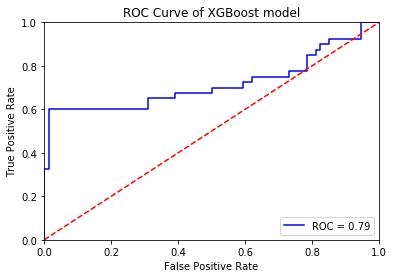

In [26]:
import warnings
warnings.filterwarnings('ignore')
import csv
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score, f1_score, accuracy_score, recall_score

import scikitplot as skplt
import matplotlib.pyplot as plt

params = list(ParameterGrid(gscv.param_grid))

model_results = []
for p in params :
    xgb_clf = xgb.XGBClassifier(**p)
    xgb_clf.fit(X_train, y_train)
    
    y_pred = xgb_clf.predict(X_test)
    y_pred_proba = xgb_clf.predict_proba(X_test)[:, 1]
    
    model_result = {'parameters' : p,
                    'accuracy' : accuracy_score(y_test, y_pred),
                    'roc_auc' : roc_auc_score(y_test, y_pred),
                    'precision' : precision_score(y_test, y_pred),
                    'recall' : recall_score(y_test, y_pred),
                    'f1_score' : f1_score(y_test, y_pred),
                    'roc_curve' : roc_curve(y_test, y_pred_proba)
                   }
    model_results.append(model_result)
    
from operator import itemgetter
sorted_models = sorted(model_results, key=itemgetter('roc_auc'), reverse=True)

fpr, tpr, thresholds = sorted_models[0]['roc_curve']
roc_auc = sorted_models[0]['roc_auc']

plt.title('ROC Curve of XGBoost model')
plt.plot(fpr, tpr, 'b', label = 'ROC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()